# AE on CIFAR10 dataset
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np

from sklearn.preprocessing import Normalizer, MinMaxScaler, minmax_scale
from sklearn.pipeline import Pipeline

## import data
- import
- normalize

In [3]:
from tensorflow.keras.datasets import cifar10
(X_train, _), (X_test, _) = cifar10.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

## build AE

In [6]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as kb
from tensorflow.keras import regularizers

encoder

In [24]:
input_img = Input(shape=(32,32,3))
regularizer = regularizers.l1(10e-5)
# model: encoder
encoded = Conv2D(32, (3, 3), activation='relu', 
                                padding='same')(input_img)
#encoded = Conv2D(64, (3, 3), activation='relu', 
#                                padding='same')(encoded)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(64, (3, 3), activation='relu', 
                                padding='same')(encoded)
#encoded = Conv2D(32, (3, 3), activation='relu', 
#                                padding='same')(encoded)                                
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)

input_encoded_before_flatten = kb.int_shape(encoded)
encoded = Flatten()(encoded)
encoder = Model(input_img, encoded)

input_encoded = Input(shape=kb.int_shape(encoded)[1:])
encoder.summary()


Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0  

decoder

In [26]:
# model: decoder
decoded = Reshape(input_encoded_before_flatten[1:])(input_encoded)
decoded = Conv2D(128, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
#decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
decoded = Conv2D(64, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
#decoded = Conv2D(64, (3, 3), activation='relu', padding='same')(decoded)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)
decoder = Model(input_encoded, decoded)

decoder.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 8192)]            0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
up_sampling2d_14 (UpSampling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 16, 64)        73792     
_________________________________________________________________
up_sampling2d_15 (UpSampling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 3)         173

autoencoder

In [27]:
# model: autoencoder
encoded = encoder(input_img)
decoded = decoder(encoded)
autoencoder = Model(input_img, decoded)

optimizer = Adam(learning_rate=0.002)
loss = tf.keras.losses.BinaryCrossentropy();

autoencoder.compile(optimizer=optimizer, loss=loss)

autoencoder.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
model_14 (Functional)        (None, 8192)              93248     
_________________________________________________________________
model_16 (Functional)        (None, 32, 32, 3)         223107    
Total params: 316,355
Trainable params: 316,355
Non-trainable params: 0
_________________________________________________________________


## train AE

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.0005)
autoencoder.fit(X_train, X_train,
                epochs=25,
                batch_size=128,
                validation_data=(X_test, X_test),
                callbacks=[early_stopping], # stop the training when no improvements are made
                verbose=1)

Epoch 1/25
391/391 [==============================] - 10s 24ms/step - loss: 0.6002 - val_loss: 0.5610
Epoch 2/25
391/391 [==============================] - 9s 22ms/step - loss: 0.5595 - val_loss: 0.5583
Epoch 3/25
391/391 [==============================] - 9s 22ms/step - loss: 0.5565 - val_loss: 0.5564
Epoch 4/25
391/391 [==============================] - 9s 24ms/step - loss: 0.5566 - val_loss: 0.5557
Epoch 5/25
391/391 [==============================] - 10s 24ms/step - loss: 0.5547 - val_loss: 0.5549
Epoch 6/25
391/391 [==============================] - 10s 25ms/step - loss: 0.5539 - val_loss: 0.5545
Epoch 7/25
391/391 [==============================] - 10s 25ms/step - loss: 0.5542 - val_loss: 0.5540
Epoch 8/25
391/391 [==============================] - 10s 24ms/step - loss: 0.5536 - val_loss: 0.5541
Epoch 9/25
391/391 [==============================] - 10s 24ms/step - loss: 0.5530 - val_loss: 0.5538
Epoch 10/25
391/391 [==============================] - 10s 24ms/step - loss: 0.5524 -

## show results

In [29]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

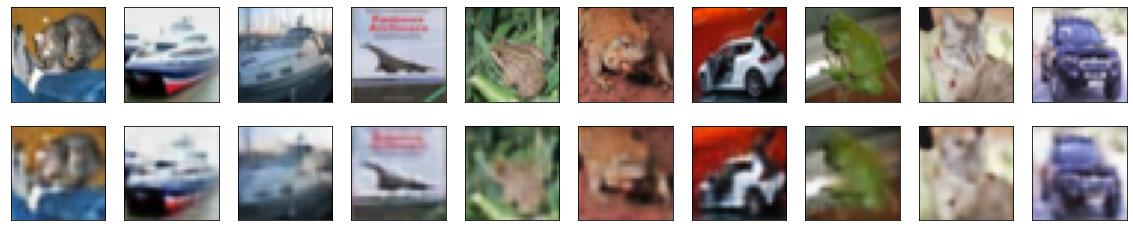

In [65]:
import matplotlib.pyplot as plt

n = 10  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    #plt.imshow(X_test_normalized[i].reshape(28, 28))
    plt.imshow(X_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## combinging labels/categories

tbd